# Unet 3D (Baseline)

In [1]:
from augmentation_generator import AugmentedGenerator
import os
import numpy as np

# get file names in the folder
PATH_DATASET = 'challenge_dataset'

file_names = os.listdir(PATH_DATASET)
N = len(file_names)

VAL_SPLIT = 0.4
BATCH_SIZE = 2

generator = AugmentedGenerator(validation_split=VAL_SPLIT, batch_size=BATCH_SIZE)


2022-11-02 12:36:22.248728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 12:36:23.473102: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-02 12:36:23.473195: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-02 12:36:23.650294: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-02 12:36:27.285317: W tensorflow/stream_executor/platform/de

In [2]:
train_data_pipeline, val_data_pipeline = generator.train_generator, generator.validation_generator

In [3]:
def crop(generator, crop_size = 48):
    while True:
        x, y = next(generator)

        crop_x, crop_y = np.zeros((len(x), crop_size, crop_size, crop_size)), np.zeros((len(x), crop_size, crop_size, crop_size))

        for i in range(len(x)):
            aneurysm_indexes = np.nonzero(y[i])

            z_min, z_max = aneurysm_indexes[0].min(), aneurysm_indexes[0].max()
            x_min, x_max = aneurysm_indexes[1].min(), aneurysm_indexes[1].max()
            y_min, y_max = aneurysm_indexes[2].min(), aneurysm_indexes[2].max()

            #print(z_min, z_max, x_min, x_max, y_min, y_max)

            z_init = np.random.randint(max(0, z_max - crop_size), max(max(0, z_max - crop_size) + 1, min(z_min + 1, x.shape[1] - crop_size)))
            y_init = np.random.randint(max(0, y_max - crop_size), max(max(0, y_max - crop_size) + 1, min(y_min + 1, x.shape[3] - crop_size)))
            x_init = np.random.randint(max(0, x_max - crop_size), max(max(0, x_max - crop_size) + 1, min(x_min + 1, x.shape[2] - crop_size)))

            #print(x.shape)

            crop_x[i] = x[i,z_init: z_init + crop_size, x_init: x_init + crop_size, y_init : y_init + crop_size]
            crop_y[i] = y[i,z_init: z_init + crop_size, x_init: x_init + crop_size, y_init : y_init + crop_size]


        

        
        yield(crop_x, crop_y)

In [4]:
crop_train = crop(train_data_pipeline)
crop_val = crop(val_data_pipeline)

In [5]:
from keras.layers import BatchNormalization, Conv3D, Cropping3D, ZeroPadding3D, Activation, Input
from keras.layers import MaxPooling3D, UpSampling3D, Conv3DTranspose, concatenate
from keras.models import Model


# input shape without batch size and we add one channel for BW color so dim=4
in_layer = Input((None, None, None, 1)) 
bn = BatchNormalization()(in_layer)
cn1 = Conv3D(8, 
             kernel_size = (1, 5, 5), 
             padding = 'same',
             activation = 'relu')(bn)
cn2 = Conv3D(8, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(cn1)
bn2 = Activation('relu')(BatchNormalization()(cn2))

dn1 = MaxPooling3D((2, 2, 2))(bn2)
cn3 = Conv3D(16, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(dn1)
bn3 = Activation('relu')(BatchNormalization()(cn3))

dn2 = MaxPooling3D((1, 2, 2))(bn3)
cn4 = Conv3D(32, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'linear')(dn2)
bn4 = Activation('relu')(BatchNormalization()(cn4))

up1 = Conv3DTranspose(16, 
                      kernel_size = (3, 3, 3),
                      strides = (1, 2, 2),
                     padding = 'same')(bn4)

cat1 = concatenate([up1, bn3])

up2 = Conv3DTranspose(8, 
                      kernel_size = (3, 3, 3),
                      strides = (2, 2, 2),
                     padding = 'same')(cat1)

pre_out = concatenate([up2, bn2])

pre_out = Conv3D(1, 
             kernel_size = (1, 1, 1), 
             padding = 'same',
             activation = 'sigmoid')(pre_out)

pre_out = Cropping3D((1, 2, 2))(pre_out) # avoid skewing boundaries
out = ZeroPadding3D((1, 2, 2))(pre_out)
sim_model = Model(inputs = [in_layer], outputs = [out])
sim_model.summary()

2022-11-02 12:36:58.860585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-02 12:36:58.869140: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-02 12:36:58.873402: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-IN2P6PG): /proc/driver/nvidia/version does not exist
2022-11-02 12:36:58.897961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   4          ['input_1[0][0]']                
 alization)                     None, 1)                                                          
                                                                                                  
 conv3d (Conv3D)                (None, None, None,   208         ['batch_normalization[0][0]']    
                                None, 8)                                                      

In [38]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.metrics import MeanIoU
from keras.losses import binary_crossentropy
from keras import backend as K
from scipy.spatial import distance_matrix


def jaccard_distance(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def jaccard_distance_weighted(y_true, y_pred, smooth=1):

    weights = 0.01 * y_true + 1000 * (1 - y_true)

    intersection = K.sum(K.abs(y_true * y_pred) * weights, axis=-1)
    sum_ = K.sum((K.abs(y_true) + K.abs(y_pred)) * weights, axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth



sim_model.compile(optimizer='adam', loss= jaccard_distance, metrics = ['binary_accuracy', 'mse', MeanIoU(2)])

weight_path="{}_weights.best.hdf5".format('jaccard')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [39]:
val_steps = int(N * VAL_SPLIT) // BATCH_SIZE
train_steps = int(N * (1 - VAL_SPLIT)) // BATCH_SIZE

crop_train = crop(train_data_pipeline)
crop_val = crop(val_data_pipeline)

sim_model.fit(crop_train, 
            steps_per_epoch=train_steps,
            epochs=20,
            validation_data=crop_val,
            validation_steps=val_steps,
            callbacks=callbacks_list)

Epoch 1/20
30/30 [==============================] - ETA: 0s - loss: 0.0243 - binary_accuracy: 0.9954 - mse: 0.0046 - mean_io_u_11: 0.4977
Epoch 1: val_loss improved from inf to 0.01967, saving model to jaccard_weights.best.hdf5
30/30 [==============================] - 41s 1s/step - loss: 0.0243 - binary_accuracy: 0.9954 - mse: 0.0046 - mean_io_u_11: 0.4977 - val_loss: 0.0197 - val_binary_accuracy: 0.9970 - val_mse: 0.0030 - val_mean_io_u_11: 0.4985 - lr: 0.0010
Epoch 2/20
30/30 [==============================] - ETA: 0s - loss: 0.0280 - binary_accuracy: 0.9948 - mse: 0.0052 - mean_io_u_11: 0.4974
Epoch 2: val_loss improved from 0.01967 to 0.01941, saving model to jaccard_weights.best.hdf5
30/30 [==============================] - 27s 917ms/step - loss: 0.0280 - binary_accuracy: 0.9948 - mse: 0.0052 - mean_io_u_11: 0.4974 - val_loss: 0.0194 - val_binary_accuracy: 0.9970 - val_mse: 0.0030 - val_mean_io_u_11: 0.4985 - lr: 0.0010
Epoch 3/20
30/30 [==============================] - ETA: 0s -

In [40]:
sim_model.load_weights(weight_path)

1/1 [==============================] - 0s 182ms/step
(48, 48, 48)


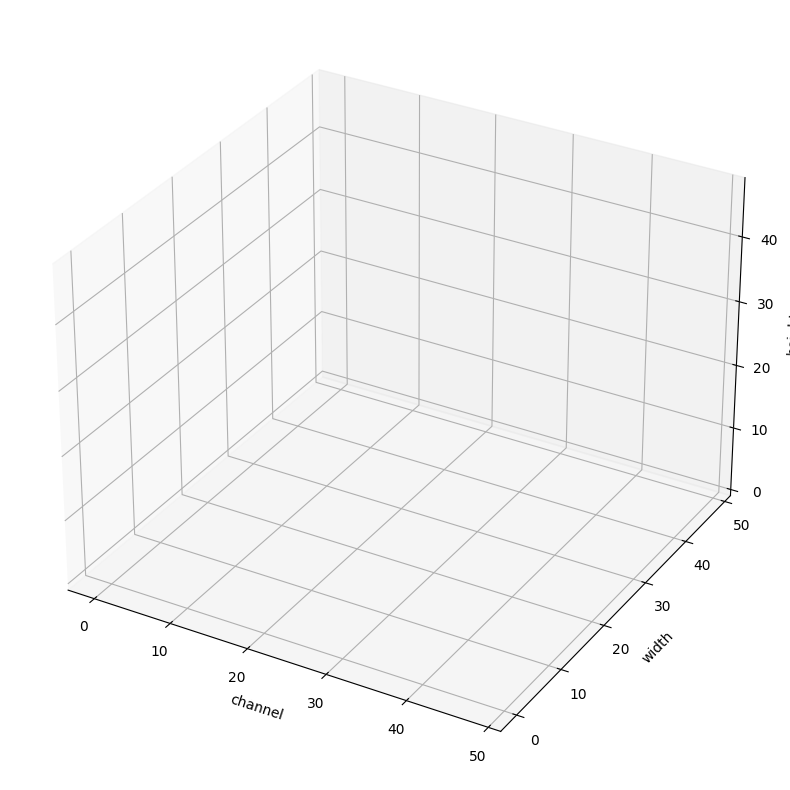

In [44]:
import matplotlib.pyplot as plt
import numpy as np

x,y = next(iter(crop_val))
idx = 0
depth = 32

im = x[idx]
lbl = y[idx]
pred = sim_model.predict(x)[idx].squeeze()

print(pred.shape)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(np.where(pred > 0.1, 1, 0), color='r', edgecolor='k', alpha=0.5)
#ax.voxels(np.where(lbl > 0.5, 1, 0) , color='g', edgecolor='k', alpha=0.5)
ax.set(xlabel='channel', ylabel='width', zlabel='height')

plt.show()